In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from scipy import integrate
from scipy import stats
import statsmodels.api as sm
import math
import seaborn as sns
from sklearn.neighbors import KernelDensity
import multiprocessing

In [2]:
path0 = '../../data/commaai/train_bags_2/0/angles_filename.csv'
path1 = '../../data/commaai/train_bags_2/1/angles_filename.csv'
path2 = '../../data/commaai/train_bags_2/2/angles_filename.csv'
path3 = '../../data/commaai/train_bags_2/3/angles_filename.csv'
path4 = '../../data/commaai/train_bags_2/4/angles_filename.csv'
path5 = '../../data/commaai/train_bags_2/5/angles_filename.csv'
path6 = '../../data/commaai/train_bags_2/6/angles_filename.csv'
df0 = pd.read_csv(path0, header = None)
df0.columns = ['filename', 'angle', 'tr_angle']
df1 = pd.read_csv(path1, header = None)
df1.columns = ['filename', 'angle', 'tr_angle']
df2 = pd.read_csv(path2, header = None)
df2.columns = ['filename', 'angle', 'tr_angle']
df3 = pd.read_csv(path3, header = None)
df3.columns = ['filename', 'angle', 'tr_angle']
df4 = pd.read_csv(path4, header = None)
df4.columns = ['filename', 'angle', 'tr_angle']
df5 = pd.read_csv(path5, header = None)
df5.columns = ['filename', 'angle', 'tr_angle']

df = df0.append(df1).append(df2).append(df3).append(df4).append(df5)
df = df.reset_index()
df = df.loc[:, ['filename','angle']]

In [78]:
df2.shape

(9416, 3)

In [3]:
df = df.loc[abs(df['angle']) < 60]

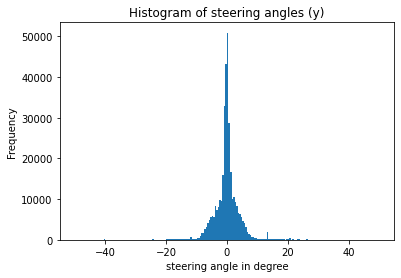

In [4]:
plt.hist(df['angle'], bins = 200)
plt.title('Histogram of steering angles (y)')
plt.xlabel('steering angle in degree')
plt.ylabel('Frequency')
plt.savefig('histogram_y.png')

In [5]:
import statsmodels.api as sm
kde = sm.nonparametric.KDEUnivariate(df['angle'])
kde.fit() # Estimate the densities

In [6]:
support = kde.support
endog = kde.endog
density = kde.density
grid = np.array([i for i in range(0, support.shape[0])])

In [7]:
def f_integral(i):
    return(integrate.trapz(density[i:(i+2)], support[i:(i+2)]))

In [8]:
with multiprocessing.Pool(20) as p:
    probs = p.map(f_integral, grid)

In [9]:
cdf = np.cumsum(np.array(probs))

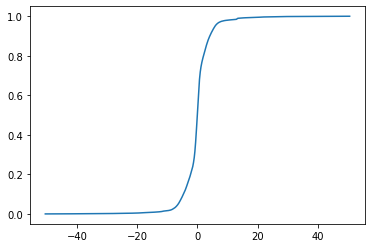

In [10]:
plt.plot(support, cdf)

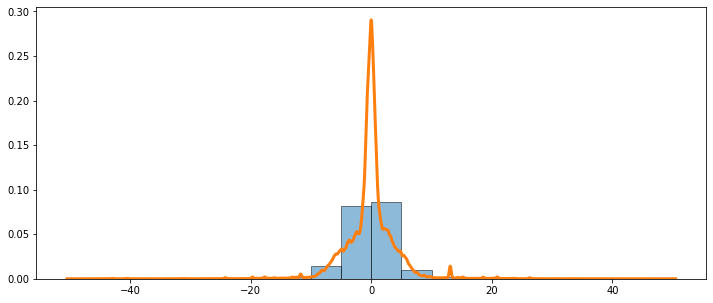

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(df['angle'], bins=20, density=True, label='Histogram from samples',
        zorder=5, edgecolor='k', alpha=0.5)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label='KDE from samples', zorder=10)

In [12]:
kde.support[max(kde.density == 0)]

array([], shape=(0, 524288), dtype=float64)

In [13]:
density = pd.DataFrame({'axes': kde.support , 'pdf': kde.density, 'cdf': cdf })

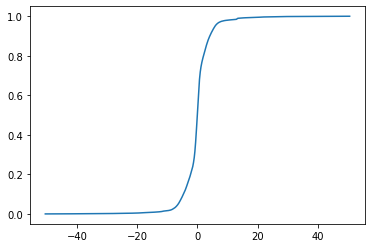

In [14]:
plt.plot(density['axes'], density['cdf'])

In [57]:
def find_closest_element(y: float, arr: np.ndarray):
    index = np.searchsorted(arr,y)
    if (index >= 1) & (index < arr.shape[0]):
        res = [arr[index - 1], arr[index]]
    elif (index < arr.shape[0]):
        return np.array(index)
    else:
        return np.array(index - 1)

    if res[0] == res[1]:
        return np.array(index - 1)
    else:
        diff_pre = np.abs(y-res[0])
        diff_aft = np.abs(y-res[1])
        if diff_pre == diff_aft:
            return np.array(index - 1)
        else:
            return index - 1 if diff_pre < diff_aft else index
def Fy(y, density):
    integral = density.loc[find_closest_element(y, density['axes']),'cdf']
    return(integral)  

In [64]:
tqdm.pandas()
df['tr_angle2'] = df['angle'].progress_apply(lambda x: norm.ppf(Fy(x, density)))

100%|██████████| 355543/355543 [02:56<00:00, 2017.56it/s]


In [65]:
df['tr_angle2'] = np.array(df['tr_angle2'] , dtype=float)

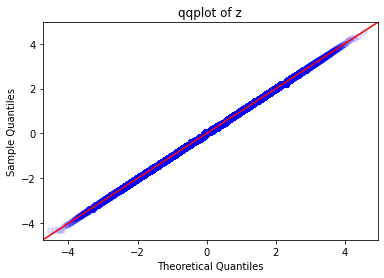

In [66]:
fig = sm.qqplot(df.loc[:,'tr_angle2'], stats.norm, fit=True, line="45")

dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[d.set_alpha(0.1) for d in dots]
plt.title('qqplot of z')
plt.savefig('qqplot_transformed_values.png')

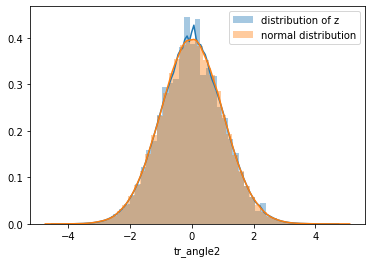

In [67]:
value = np.random.normal(loc=0,scale=1,size=df['tr_angle2'].shape[0])
f, ax = plt.subplots(1, 1)
sns.distplot(df['tr_angle2'], label = 'distribution of z')
sns.distplot(value, label = 'normal distribution')
ax.legend()
f.savefig('histogram_z_vs_normal_distr.png')

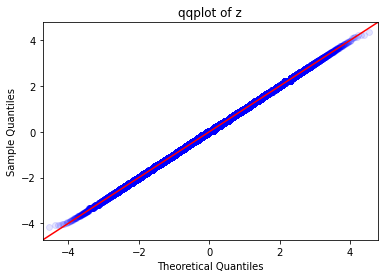

In [68]:
fig = sm.qqplot(df.loc[abs(df['angle']) < 50, 'tr_angle2'], stats.norm, fit=True, line="45")

dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[d.set_alpha(0.1) for d in dots]
plt.title('qqplot of z')
plt.savefig('qqplot_transformed_values.png')


In [69]:
# Pearson test for normality
k2, p = stats.normaltest(df['tr_angle2'])

In [70]:
p

0.39709060405294255

In [71]:
from scipy import stats
# kolmogorov smirnhoff test for normality
k2, p = stats.kstest(df['tr_angle2'], 'norm')
p

2.074320558350055e-163

In [74]:
# save density if everything is ok
density.to_csv('../../data/commaai/density/gaussian_density.csv', index=False)